In this notebook, we're attempting to shrink the label space by utilizing building footprint ROI data

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, ogr, osr

%matplotlib inline

In [2]:
ROOT_PATH = Path(os.getcwd()).parent.as_posix()
DATASET_PATH = Path(ROOT_PATH, "datasets/storm-damage-detection/working").as_posix()
MAP_GTIFF_PATH = Path(DATASET_PATH, "unprep/raw/Post_Event_San_Juan.tif").as_posix()
ROI_SHAPEFILE_PATH = Path(DATASET_PATH, "unprep/building_footprint_roi/projected/building_footprint_roi_projected.shp").as_posix()
ROI_GTIFF_PATH = Path(DATASET_PATH, "unprep/building_footprint_roi/building_footprint_roi_projected.tif").as_posix()
BUILDING_COVERAGE_PATH = Path(DATASET_PATH, "unprep/building_footprint_roi/building_coverage.csv").as_posix()

In [5]:
dummy_fnames = open(Path(DATASET_PATH, "unprep/all_grids/grid_jpeg.txt"), "r").read().splitlines()
file_index_mapper = {fname: f"{i:03}" for i, fname in enumerate(dummy_fnames)}

In [8]:
file_index_mapper

{'tile_0_122.jpg': '000',
 'tile_19_62.jpg': '001',
 'tile_36_81.jpg': '002',
 'tile_40_123.jpg': '003',
 'tile_17_141.jpg': '004',
 'tile_42_66.jpg': '005',
 'tile_50_137.jpg': '006',
 'tile_31_88.jpg': '007',
 'tile_56_13.jpg': '008',
 'tile_10_46.jpg': '009',
 'tile_50_123.jpg': '010',
 'tile_10_52.jpg': '011',
 'tile_42_72.jpg': '012',
 'tile_66_109.jpg': '013',
 'tile_40_137.jpg': '014',
 'tile_0_136.jpg': '015',
 'tile_6_16.jpg': '016',
 'tile_36_95.jpg': '017',
 'tile_19_76.jpg': '018',
 'tile_45_53.jpg': '019',
 'tile_17_73.jpg': '020',
 'tile_38_90.jpg': '021',
 'tile_8_13.jpg': '022',
 'tile_51_26.jpg': '023',
 'tile_43_7.jpg': '024',
 'tile_1_37.jpg': '025',
 'tile_31_143.jpg': '026',
 'tile_63_94.jpg': '027',
 'tile_66_121.jpg': '028',
 'tile_63_80.jpg': '029',
 'tile_66_135.jpg': '030',
 'tile_20_4.jpg': '031',
 'tile_1_23.jpg': '032',
 'tile_58_16.jpg': '033',
 'tile_51_32.jpg': '034',
 'tile_38_84.jpg': '035',
 'tile_17_67.jpg': '036',
 'tile_21_143.jpg': '037',
 'tile_6

In [3]:
def convert_shapefile_to_gtiff(map_path, shapefile_path, output_path):
    # Read shapefile
    shapefile_ds = ogr.Open(shapefile_path)
    shapefile_layer = shapefile_ds.GetLayer()

    # Read attributes of reference image
    map_ds = gdal.Open(map_path, gdal.GA_ReadOnly)
    map_gt = map_ds.GetGeoTransform()
    map_proj = map_ds.GetProjection()
    map_width = map_ds.RasterXSize
    map_height = map_ds.RasterYSize

    # Create output geotiff file
    output_ds = gdal.GetDriverByName("GTiff").Create(output_path, map_width, map_height, 1, gdal.GDT_Byte, options=['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES'])
    output_ds.SetProjection(map_proj)
    output_ds.SetGeoTransform(map_gt)

    # Rasterize polygons from shapefile
    band = output_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    gdal.RasterizeLayer(output_ds, [1], shapefile_layer, burn_values=[1])

    # Close dataset
    output_ds.FlushCache()
    del output_ds

In [4]:
convert_shapefile_to_gtiff(map_path=MAP_GTIFF_PATH, shapefile_path=ROI_SHAPEFILE_PATH, output_path=ROI_GTIFF_PATH)

C:\miniconda3\envs\storm-damage-detection-cuda\Lib\site-packages\osgeo\ogr.py:593: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [9]:
roi_ds = gdal.Open(ROI_GTIFF_PATH)
map_ds = gdal.Open(MAP_GTIFF_PATH)

print(f"{roi_ds.RasterXSize=}, {roi_ds.RasterYSize=}")
print(f"{map_ds.RasterXSize=}, {map_ds.RasterYSize=}")

roi_ds.RasterXSize=38259, roi_ds.RasterYSize=74602
map_ds.RasterXSize=38259, map_ds.RasterYSize=74602


C:\miniconda3\envs\storm-damage-detection-cuda\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [12]:
grid_x = 512
grid_y = 512

roi_ds = gdal.Open(ROI_GTIFF_PATH)
width = roi_ds.RasterXSize
height = roi_ds.RasterYSize

# Calculate number of tiles in each dimension
num_tiles_x = (width // grid_x)
num_tiles_y = (height // grid_y)

print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

pos_info = []
all_roi_arr = np.zeros((10730, 512, 512), dtype=bool)
all_map_arr = np.zeros((10730, 3, 512, 512), dtype=np.uint8)

# Iterate over each tile 
for i in range(num_tiles_x): # col index
    for j in range(num_tiles_y): # row index
        x_offset = i * grid_x
        y_offset = j * grid_y

        tile_width = min(grid_x, width - x_offset)
        tile_height = min(grid_y, height - y_offset)
        
        tile_data = roi_ds.GetRasterBand(1).ReadAsArray(x_offset, y_offset, tile_width, tile_height) # (512, 512)
        has_building = np.any(tile_data == 1)
        building_proportion_in_tile = np.sum(tile_data) / (grid_x * grid_y)

        map_arr = []
        for band in range(1, 4):
            tile_data2 = map_ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
            map_arr.append(tile_data2)

        map_arr = np.array(map_arr) # (3, 512, 512)
        

        dummy_fname = f"tile_{i}_{j}.jpg"
        file_index = int(file_index_mapper[dummy_fname])
        all_roi_arr[file_index, :, :] = tile_data
        all_map_arr[file_index, :, :, :] = map_arr
        


        pos_info.append(
            {
                "col_row": (i, j),
                "has_building": has_building,
                "coverage": building_proportion_in_tile,
                "dummy_fname": f"tile_{i}_{j}.jpg"
            }
        )

Total number of tiles: 10730


In [13]:
df = pd.DataFrame(pos_info)
df

,col_row,has_building,coverage,dummy_fname
0,"(0, 0)",False,0.000000,tile_0_0.jpg
1,"(0, 1)",False,0.000000,tile_0_1.jpg
2,"(0, 2)",False,0.000000,tile_0_2.jpg
3,"(0, 3)",False,0.000000,tile_0_3.jpg
4,"(0, 4)",False,0.000000,tile_0_4.jpg
...,...,...,...,...
10725,"(73, 140)",True,0.000137,tile_73_140.jpg
10726,"(73, 141)",False,0.000000,tile_73_141.jpg
10727,"(73, 142)",False,0.000000,tile_73_142.jpg
10728,"(73, 143)",False,0.000000,tile_73_143.jpg


In [14]:
df["file_index"] = df["dummy_fname"].map(lambda x: file_index_mapper[x])
df

,col_row,has_building,coverage,dummy_fname,file_index
0,"(0, 0)",False,0.000000,tile_0_0.jpg,3636
1,"(0, 1)",False,0.000000,tile_0_1.jpg,3851
2,"(0, 2)",False,0.000000,tile_0_2.jpg,3186
3,"(0, 3)",False,0.000000,tile_0_3.jpg,2957
4,"(0, 4)",False,0.000000,tile_0_4.jpg,4445
...,...,...,...,...,...
10725,"(73, 140)",True,0.000137,tile_73_140.jpg,6942
10726,"(73, 141)",False,0.000000,tile_73_141.jpg,7087
10727,"(73, 142)",False,0.000000,tile_73_142.jpg,7757
10728,"(73, 143)",False,0.000000,tile_73_143.jpg,7608


In [15]:
df = df[["file_index", "has_building", "coverage", "dummy_fname"]].sort_values(by="file_index")
df

,file_index,has_building,coverage,dummy_fname
122,000,True,0.095436,tile_0_122.jpg
2817,001,True,0.385014,tile_19_62.jpg
5301,002,True,0.302933,tile_36_81.jpg
5923,003,True,0.042225,tile_40_123.jpg
2606,004,True,0.004066,tile_17_141.jpg
...,...,...,...,...
4497,9995,False,0.000000,tile_31_2.jpg
6700,9996,True,0.398483,tile_46_30.jpg
2068,9997,True,0.146816,tile_14_38.jpg
800,9998,True,0.387959,tile_5_75.jpg


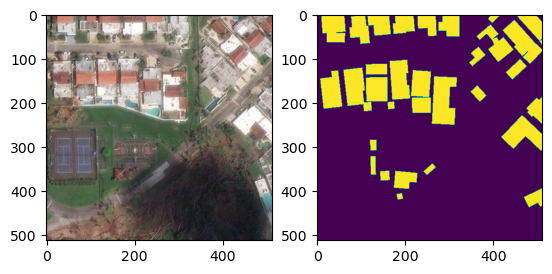

In [49]:
# Code for double check matching of indices
file_index = 10726
plt.subplot(121)
plt.imshow(np.transpose(all_map_arr[file_index, :, :, :], (1, 2, 0)))
plt.subplot(122)
plt.imshow(all_roi_arr[file_index, :, :])
plt.show()

In [28]:
df.to_csv(BUILDING_COVERAGE_PATH, index=False)

In [29]:
df = pd.read_csv(BUILDING_COVERAGE_PATH)
df

,file_index,has_building,coverage,dummy_fname
0,0,True,0.095436,tile_0_122.jpg
1,1,True,0.385014,tile_19_62.jpg
2,2,True,0.302933,tile_36_81.jpg
3,3,True,0.042225,tile_40_123.jpg
4,4,True,0.004066,tile_17_141.jpg
...,...,...,...,...
10725,9995,False,0.000000,tile_31_2.jpg
10726,9996,True,0.398483,tile_46_30.jpg
10727,9997,True,0.146816,tile_14_38.jpg
10728,9998,True,0.387959,tile_5_75.jpg


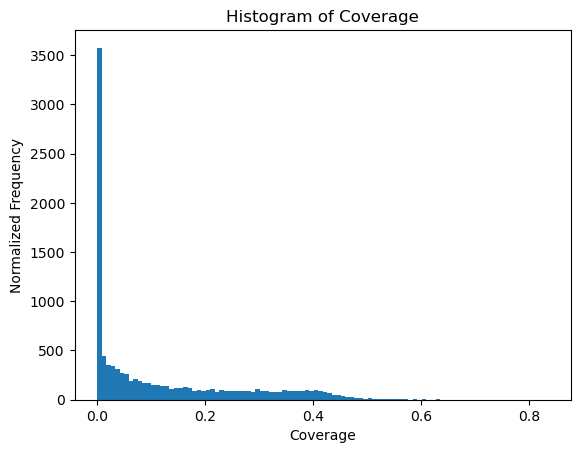

In [30]:
coverage = df["coverage"].tolist()
plt.hist(coverage, 100)
plt.xlabel('Coverage')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of Coverage')
plt.show()

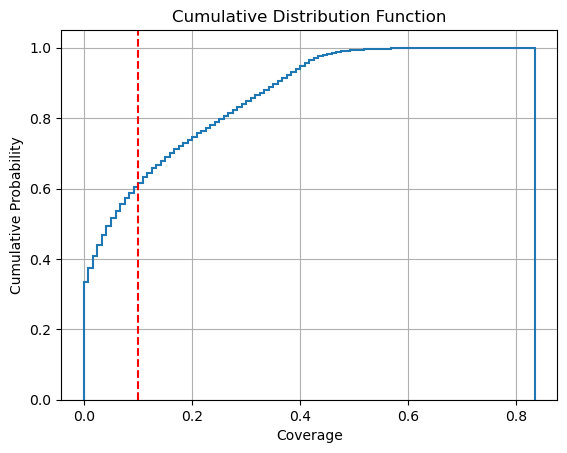

In [31]:
plt.hist(coverage, bins=100, density=True, cumulative=True, histtype='step', linewidth=1.5)
plt.axvline(x=0.1, color="r", linestyle="--")
plt.xlabel('Coverage')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function')
plt.grid(True)
plt.show()

- At least 30% of tiles have no buildings in them, it's a waste of effort if we include them in the dataset to be labelled
- Empirically, we should set the coverage threshold as **0.1**, then we can filter out more than half of the entire dataset (left with 40%)

## Create a new folder that contain the filtered grids

In [32]:
ORI_POST_EVENT_PATH = Path(DATASET_PATH, "unprep/all_grids/post_event")
NEW_POST_EVENT_PATH = Path(DATASET_PATH, "unprep/all_grids/post_event_filtered")
os.makedirs(NEW_POST_EVENT_PATH, exist_ok=True)

In [33]:
# Extract the file index of coverage >= 0.1
df_filtered = df.loc[df["coverage"] >= 0.1]
filtered_ixs = set([f"{x:03}" for x in df_filtered["file_index"].tolist()])
df_filtered

,file_index,has_building,coverage,dummy_fname
1,1,True,0.385014,tile_19_62.jpg
2,2,True,0.302933,tile_36_81.jpg
5,5,True,0.139576,tile_42_66.jpg
7,7,True,0.183407,tile_31_88.jpg
9,9,True,0.258347,tile_10_46.jpg
...,...,...,...,...
10720,9990,True,0.139694,tile_41_100.jpg
10726,9996,True,0.398483,tile_46_30.jpg
10727,9997,True,0.146816,tile_14_38.jpg
10728,9998,True,0.387959,tile_5_75.jpg


In [34]:
filtered_ixs

{'5197',
 '8870',
 '7592',
 '4853',
 '9906',
 '3277',
 '7709',
 '1950',
 '9524',
 '2761',
 '4315',
 '782',
 '9092',
 '4473',
 '2258',
 '9711',
 '187',
 '6312',
 '4705',
 '3365',
 '5565',
 '3893',
 '2770',
 '439',
 '7961',
 '7405',
 '8135',
 '5468',
 '7581',
 '2508',
 '7830',
 '5451',
 '5593',
 '7065',
 '1011',
 '5477',
 '2183',
 '2665',
 '1082',
 '2816',
 '8446',
 '9375',
 '3831',
 '6610',
 '7531',
 '9287',
 '8109',
 '6433',
 '8320',
 '4789',
 '8605',
 '132',
 '3763',
 '7469',
 '1558',
 '8159',
 '7657',
 '159',
 '3372',
 '3426',
 '8957',
 '1969',
 '4153',
 '9251',
 '9931',
 '1849',
 '4695',
 '4802',
 '5631',
 '7341',
 '6324',
 '3688',
 '4878',
 '1814',
 '4275',
 '1024',
 '9575',
 '4314',
 '2105',
 '5126',
 '7856',
 '6908',
 '7232',
 '1286',
 '875',
 '10398',
 '876',
 '8404',
 '9374',
 '10318',
 '4320',
 '1176',
 '3497',
 '6587',
 '5187',
 '9652',
 '1199',
 '5947',
 '263',
 '2476',
 '3712',
 '3327',
 '7772',
 '8160',
 '1497',
 '1905',
 '2003',
 '5203',
 '8078',
 '4669',
 '5353',
 '9213'

In [35]:
count = 0
for fname in os.listdir(ORI_POST_EVENT_PATH):
    file_ix = fname.split("_")[-1].rstrip(".jpg")
    if not file_ix in filtered_ixs:
        continue

    # copy file to the new path
    shutil.copyfile(Path(ORI_POST_EVENT_PATH, fname), Path(NEW_POST_EVENT_PATH, fname))
    count += 1
print(f"Copied {count} files!")

Copied 4257 files!
